In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.pipeline import Pipeline

from sklearn.preprocessing import MinMaxScaler

from imblearn.over_sampling import SMOTE, BorderlineSMOTE, SVMSMOTE, ADASYN

from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import GridSearchCV, HalvingGridSearchCV, train_test_split, RepeatedStratifiedKFold, cross_val_score, learning_curve
from sklearn.metrics import classification_report, fbeta_score, confusion_matrix, precision_recall_curve, auc, make_scorer

In [2]:
accepted_loans = pd.read_csv('../input/ml-project-elite/elite.csv')

In [3]:
X = accepted_loans.loc[:, accepted_loans.columns != 'loan_paid'].values
y = accepted_loans['loan_paid'].values

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [5]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=42)

In [6]:
minmax_scaler = ('minmax', MinMaxScaler())

In [7]:
smote = ('smote', SMOTE(sampling_strategy=1.0, random_state=42))
smote_param_grid = {
    'smote__sampling_strategy': [0.8, 0.9, 1.0]
    #'smote__k_neighbors': [3, 5, 10, 15]
}

In [8]:
mlp = ('mlp', MLPClassifier(max_iter=100, random_state=42, early_stopping=True, activation='logistic', n_iter_no_change=20)) 
mlp_param_grid = {
    'mlp__hidden_layer_sizes' : [(100,), (100, 100), (50, 50, 50), (50, 100, 50)],
}

In [9]:
# Metric
f_onehalf_scorer = make_scorer(fbeta_score, beta=0.5)

In [10]:
def plot_learning_curve(
    estimator,
    title,
    X,
    y,
    axes=None,
    ylim=None,
    cv=cv,
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5),
):
    if axes is None:
        _, axes = plt.subplots(3, 1, figsize=(15, 15))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        scoring=f_onehalf_scorer,
        return_times=True,
        random_state=42
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes[0].fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    axes[0].plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes[0].plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, "o-")
    axes[1].fill_between(
        train_sizes,
        fit_times_mean - fit_times_std,
        fit_times_mean + fit_times_std,
        alpha=0.1,
    )
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    fit_time_argsort = fit_times_mean.argsort()
    fit_time_sorted = fit_times_mean[fit_time_argsort]
    test_scores_mean_sorted = test_scores_mean[fit_time_argsort]
    test_scores_std_sorted = test_scores_std[fit_time_argsort]
    axes[2].grid()
    axes[2].plot(fit_time_sorted, test_scores_mean_sorted, "o-")
    axes[2].fill_between(
        fit_time_sorted,
        test_scores_mean_sorted - test_scores_std_sorted,
        test_scores_mean_sorted + test_scores_std_sorted,
        alpha=0.1,
    )
    axes[2].set_xlabel("fit_times") 
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

In [11]:
def pooled_var(stds):
    n = 30 # size of each group
    return np.sqrt(sum((n-1)*(stds**2))/ len(stds)*(n-1))

def plot_search_results(search):
  df = pd.DataFrame(search.cv_results_)
  results = ['mean_test_score',
            'mean_train_score',
            'std_test_score', 
            'std_train_score']

  fig, axes = plt.subplots(1, len(param_grid), 
                          figsize = (7*len(param_grid), 5),
                          sharey='row')
  axes[0].set_ylabel("Score", fontsize=25)


  for idx, (param_name, param_range) in enumerate(param_grid.items()):
      grouped_df = df.groupby(f'param_{param_name}')[results]\
          .agg({'mean_train_score': 'mean',
                'mean_test_score': 'mean',
                'std_train_score': 'mean',
                'std_test_score': 'mean'})

      previous_group = df.groupby(f'param_{param_name}')[results]
      axes[idx].set_xlabel(param_name, fontsize=30)
      axes[idx].set_ylim(0.0, 1.1)
      lw = 2
      axes[idx].plot(param_range, grouped_df['mean_train_score'], label="Training score",
                  color="darkorange", lw=lw)
      axes[idx].fill_between(param_range,grouped_df['mean_train_score'] - grouped_df['std_train_score'],
                      grouped_df['mean_train_score'] + grouped_df['std_train_score'], alpha=0.2,
                      color="darkorange", lw=lw)
      axes[idx].plot(param_range, grouped_df['mean_test_score'], label="Cross-validation score",
                  color="navy", lw=lw)
      axes[idx].fill_between(param_range, grouped_df['mean_test_score'] - grouped_df['std_test_score'],
                      grouped_df['mean_test_score'] + grouped_df['std_test_score'], alpha=0.2,
                      color="navy", lw=lw)

  handles, labels = axes[0].get_legend_handles_labels()
  fig.suptitle('Validation curves', fontsize=40)
  fig.legend(handles, labels, loc=8, ncol=2, fontsize=20)

  fig.subplots_adjust(bottom=0.25, top=0.85)  
  plt.show()

In [12]:
def print_result_df(search):
  keeping_columns = ['params', 'mean_train_score', 'std_train_score', 'mean_test_score', 'std_test_score', 'mean_fit_time', 'std_fit_time']
  df = pd.DataFrame(search.cv_results_)
  df = df[keeping_columns].sort_values(by='mean_test_score', ascending=False)
  return df.iloc[:10, :]

In [13]:
def print_best_model_result(search, name):
  print("Best parameter (CV score=):" % search.best_score_)
  best_model = search.best_estimator_
  print(best_model)

  y_pred = best_model.predict(X_test)

  print(classification_report(y_test, y_pred))
  print(confusion_matrix(y_test, y_pred))
  
  f_onehalf_score = fbeta_score(y_test, y_pred, beta=0.5)
  print('f0.5_score=', f_onehalf_score)

  try :
    y_score = best_model.predict_proba(X_test)[:, 1]
    # calculate precision and recall for each threshold
    precision, recall, threshold = precision_recall_curve(y_test, y_score)
    # calculate scores
    pr_auc = auc(recall, precision)
    print('pr_auc_score=', pr_auc)

    # calculate the no skill line as the proportion of the positive class
    no_skill = len(y_test[y_test==1]) / len(y_test)
    # plot the no skill precision-recall curve
    plt.figure(figsize=(10, 7))
    plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
    # plot the model precision-recall curve
    plt.plot(recall, precision, marker='.', label=name)
    plt.title(f'{name}(pr_auc={pr_auc})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()
  except:
    pass

  plot_learning_curve(best_model, name, X_train, y_train, cv=cv, n_jobs=-1 )
  plt.show()

  return best_model

In [14]:
pipe = Pipeline(steps=[minmax_scaler, mlp])
print("MinMaxScaler MLP")

MinMaxScaler MLP


In [15]:
#param_grid = {**mlp_param_grid}
param_grid = {}

In [16]:
search = HalvingGridSearchCV(pipe, param_grid, scoring=f_onehalf_scorer, cv=cv, verbose=3, return_train_score=True)

In [17]:
search.fit(X_train, y_train)

n_iterations: 1
n_required_iterations: 1
n_possible_iterations: 1
min_resources_: 1074704
max_resources_: 1074704
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 1
n_resources: 1074704
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 1/5] END ..............., score=(train=0.912, test=0.912) total time=10.6min


/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 2/5] END ..............., score=(train=0.919, test=0.918) total time= 9.8min


/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 3/5] END ..............., score=(train=0.914, test=0.915) total time=10.8min


/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 4/5] END ..............., score=(train=0.914, test=0.913) total time=12.1min


/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 5/5] END ..............., score=(train=0.912, test=0.911) total time=10.6min


/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


HalvingGridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=1, n_splits=5, random_state=42),
                    estimator=Pipeline(steps=[('minmax', MinMaxScaler()),
                                              ('mlp',
                                               MLPClassifier(activation='logistic',
                                                             early_stopping=True,
                                                             max_iter=100,
                                                             n_iter_no_change=20,
                                                             random_state=42))]),
                    param_grid={}, scoring=make_scorer(fbeta_score, beta=0.5),
                    verbose=3)

In [18]:
print_result_df(search)

,params,mean_train_score,std_train_score,mean_test_score,std_test_score,mean_fit_time,std_fit_time
0,{},0.914479,0.002467,0.913958,0.002515,645.883598,44.239567


In [19]:
#plot_search_results(search)

Best parameter (CV score=):
Pipeline(steps=[('minmax', MinMaxScaler()),
                ('mlp',
                 MLPClassifier(activation='logistic', early_stopping=True,
                               max_iter=100, n_iter_no_change=20,
                               random_state=42))])
              precision    recall  f1-score   support

           0       0.72      0.64      0.68     53638
           1       0.91      0.94      0.93    215038

    accuracy                           0.88    268676
   macro avg       0.82      0.79      0.80    268676
weighted avg       0.87      0.88      0.88    268676

[[ 34132  19506]
 [ 13185 201853]]
f0.5_score= 0.9171184416896718
pr_auc_score= 0.9844349767891873


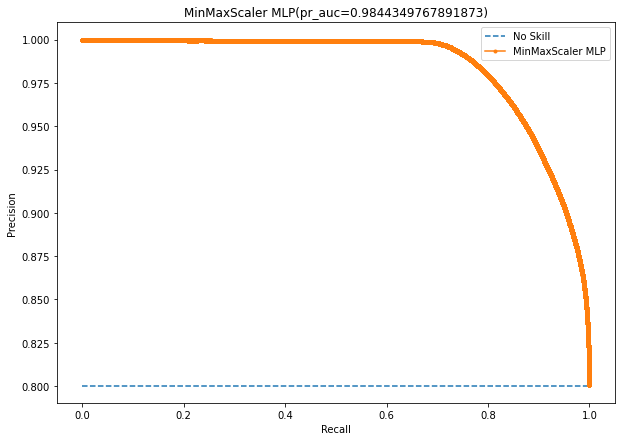

/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


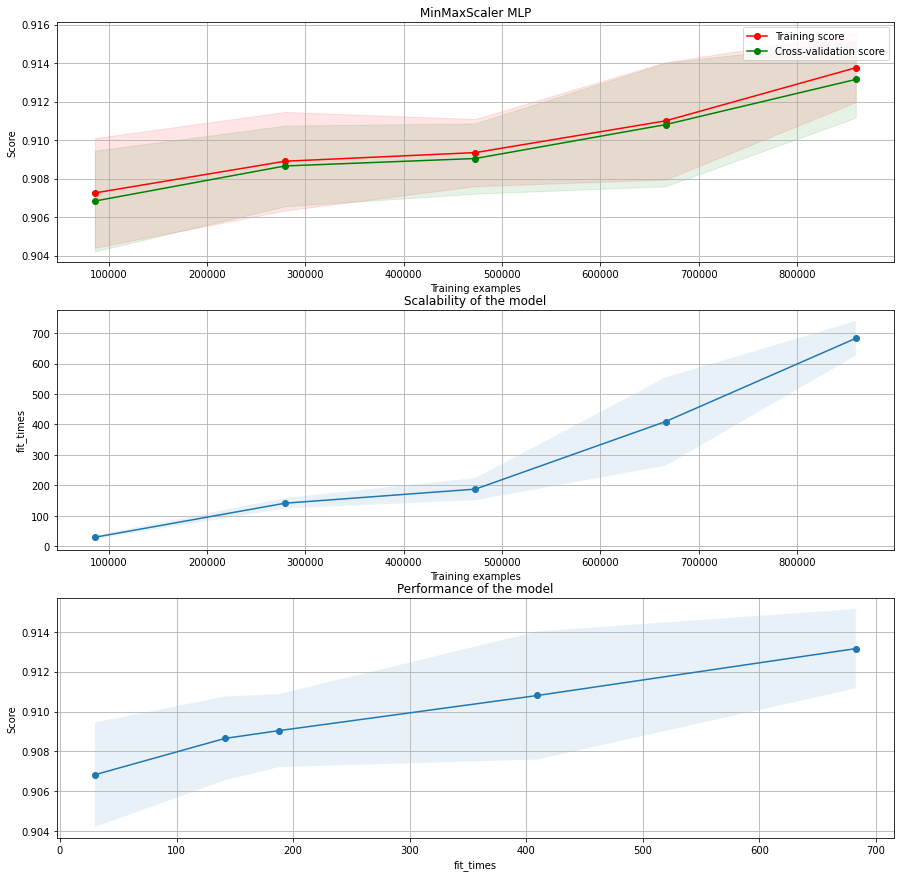

Pipeline(steps=[('minmax', MinMaxScaler()),
                ('mlp',
                 MLPClassifier(activation='logistic', early_stopping=True,
                               max_iter=100, n_iter_no_change=20,
                               random_state=42))])

In [20]:
print_best_model_result(search, 'MinMaxScaler MLP')